# Probabilistic Integral Circuits

In this notebook, we will show an alternative way of learning the parameters of tensorized folded (probabilistic) circuits.

This technique is actually based on another model class called *Probabilistic Integral Circuit* (PIC), which extends Probabilistic Circuits (PCs) by adding *integral units*, which allow modelling continuous latent variables.

Fortunately enough, we do **not** need to fully understand PICs to apply them! In fact, from an application point of view, all we need to do is replacing every folded tensor parameter with a neural net whose output is an equally-sized tensor! Therefore, the actual parameters we are going to optimize are those of such neural nets, and not the original tensors. This is it -- nothing less, nothing more.

To showcase this alternative parameter learning scheme, we will first instantiate a folded circuit as shown in ```learning-a-circuit.ipynb```.

In [1]:
from cirkit.templates import circuit_templates
from cirkit.pipeline import compile
import random
import numpy as np
import torch


# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda')

symbolic_circuit = circuit_templates.image_data(
    (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
    region_graph='quad-graph',  # Select the structure of the circuit to follow the QuadGraph region graph
    input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
    num_input_units=64,         # Each input layer consists of 64 Categorical input units
    sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense sum layers and hadamard product layers
    num_sum_units=64,           # Each dense sum layer consists of 64 sum units
    sum_weight_param=circuit_templates.Parameterization(
        activation='none',      # Do not use any parameterization
        initialization='normal' # Initialize the sum weights by sampling from a standard normal distribution
    )
)
circuit = compile(symbolic_circuit)

The one above is the very same circuit from ```learning-a-circuit.ipynb```. Let's now print some stuff related to its first and second layer.

In [2]:
print(circuit.nodes[0])
print(circuit.nodes[0].probs().shape)

TorchCategoricalLayer(
  folds: 784  channels: 1  variables: 1  output-units: 64
  input-shape: (784, 1, -1, 1)
  output-shape: (784, -1, 64)
  (probs): TorchParameter(
    shape: (784, 64, 1, 256)
    (0): TorchTensorParameter(output-shape: (784, 64, 1, 256))
    (1): TorchSoftmaxParameter(
      input-shapes: [(784, 64, 1, 256)]
      output-shape: (784, 64, 1, 256)
    )
  )
)
torch.Size([784, 64, 1, 256])


The first layer is an input categorical layer, which models the 784 gray-scale pixels using a folded tensor of shape (784, 64, 1, 256).

In [3]:
print(circuit.nodes[1])
print(circuit.nodes[1].weight().shape)

TorchDenseLayer(
  folds: 1568  arity: 1  input-units: 64  output-units: 64
  input-shape: (1568, 1, -1, 64)
  output-shape: (1568, -1, 64)
  (weight): TorchParameter(
    shape: (1568, 64, 64)
    (0): TorchTensorParameter(output-shape: (1568, 64, 64))
  )
)
torch.Size([1568, 64, 64])


The second layer is a TorchDenseLayer whose shape is (1568, 64, 64).

## Converting PCs to Quadrature PCs (QPCs)

As we mentioned earlier, all we need to do is replacing every folded tensor parameter with a neural net whose output returns an equally-sized tensor. Therefore, instead of training tensors, we will be training neural nets that output tensors.

We can do such *replacement* in one line by using the API ```pc2qpc```. Here QPC stands for *Quadrature* PC, and it is simply a discretization of the underlying PIC which is parameterized by neural nets.

In [4]:
from cirkit.backend.torch.parameters.pic import pc2qpc
pc2qpc(circuit, integration_method="trapezoidal", net_dim=256)

Let's now inspect again the first layer of ```circuit```.

In [5]:
print(circuit.nodes[0])
print(circuit.nodes[0].probs().shape)

TorchCategoricalLayer(
  folds: 784  channels: 1  variables: 1  output-units: 64
  input-shape: (784, 1, -1, 1)
  output-shape: (784, -1, 64)
  (probs): PICInputNet(
    (reparam): TorchSoftmaxParameter(
      input-shapes: [(784, 64, 1, 256)]
      output-shape: (784, 64, 1, 256)
    )
    (net): Sequential(
      (0): FourierLayer(1, 256, sigma=1.0)
      (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (2): Tanh()
      (3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
  )
)
torch.Size([784, 64, 1, 256])


We see that the first layer is now parameterized by a neural net (instance of the class ```PICInputNet```), and that its evaluation delivers an equally-shaped tensor as before, i.e. (784, 64, 1, 256).

Let's check now the second layer.

In [6]:
print(circuit.nodes[1])
print(circuit.nodes[1].weight().shape)
print(torch.all(torch.isclose(circuit.nodes[1].weight().sum(-1), torch.tensor(1.0))))

TorchDenseLayer(
  folds: 1568  arity: 1  input-units: 64  output-units: 64
  input-shape: (1568, 1, -1, 64)
  output-shape: (1568, -1, 64)
  (weight): PICInnerNet(
    (net): Sequential(
      (0): FourierLayer(2, 256, sigma=1.0)
      (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (2): Tanh()
      (3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (4): Tanh()
      (5): Conv1d(401408, 1568, kernel_size=(1,), stride=(1,))
      (6): Softplus(beta=1.0, threshold=20.0)
    )
  )
)
torch.Size([1568, 64, 64])
tensor(True)


Similarly, the second layer is parameterized by a neural net (instance of the class ```PICInnerNet```), and its evaluation delivers an equally-shaped tensor as before, i.e. (1568, 64, 64). Finally, note that output tensors from neural nets associated to inner layers are already normalized, in the sense that they sum up to 1 over the last dimension, therefore leading to a PC with normalization constant equal to 1.

That is it, we are done! 🎉 We can now even forget about PICs, and just train as in ```learning-a-circuit.ipynb``` as we do next. However, if you want to learn more about PICs (and understand the input arguments of ```pc2qpc```) please check: https://arxiv.org/abs/2406.06494.

## Learning a Probabilistic (Integral) Circuit

In [7]:
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Flatten the images and set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.005)

In [8]:
num_epochs = 5
step_idx = 0
running_loss = 0.0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch, _) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device).unsqueeze(dim=1)

        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        step_idx += 1
        if step_idx % 100 == 0:
            print(f"Step {step_idx}: Average NLL: {running_loss / (100 * len(batch)):.3f}")
            running_loss = 0.0

Step 100: Average NLL: 860.552
Step 200: Average NLL: 742.246
Step 300: Average NLL: 710.612
Step 400: Average NLL: 695.550
Step 500: Average NLL: 674.847
Step 600: Average NLL: 672.627
Step 700: Average NLL: 666.215
Step 800: Average NLL: 659.338
Step 900: Average NLL: 661.105
Step 1000: Average NLL: 654.747
Step 1100: Average NLL: 656.898


We evaluate our probabilistic circuit on the test data by computing the average log-likelihood and bits per dimension.

In [9]:
with torch.no_grad():
    test_lls = 0.0

    for batch, _ in test_dataloader:
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device).unsqueeze(dim=1)

        # Compute the log-likelihoods of the batch
        log_likelihoods = circuit(batch)

        # Accumulate the log-likelihoods
        test_lls += log_likelihoods.sum().item()

    # Compute average test log-likelihood and bits per dimension
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (28 * 28 * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd:.3f}")

Average test LL: -651.333
Bits per dimension: 1.199


Next, similarly to the evaluation of the probabilistic circuit learned in [learning-a-circuit.ipynb](learning-a-circuit.ipynb), we sample some images that will have a higher quality as they the circuit was learned as a PIC.

In [10]:
from cirkit.backend.torch.queries import SamplingQuery

num_samples = 6

sampling_query = SamplingQuery(circuit)
samples, mixture_samples = sampling_query(num_samples=num_samples)

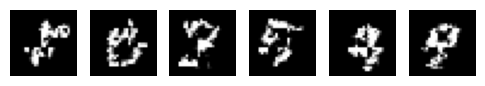

In [11]:
import matplotlib.pyplot as plt

samples = samples.squeeze(dim=1).view(-1, 28, 28)
samples = samples.cpu().numpy()

plt.figure(figsize=(num_samples, 1))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.show()